## Dự đoán giá lúa

### Import thư viện

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline


import xgboost as xgb

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

### Dữ liệu

In [52]:
df = pd.read_csv('./data.csv',  parse_dates=['date'], index_col='date')

Dữ liệu giá lúa gạo được thu thập từ trang https://data.humdata.org/dataset/wfp-food-prices-for-viet-nam từ 15/1/2008 đến 15/9/2023 theo từng tháng, gồm 189 dòng dữ liệu. 

Dữ liệu gồm 2 cột:  

“date”: ngày ghi nhận giá lúa gạo (chọn làm index) 

“price”: giá lúa gạo 

In [53]:
df.head()

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


### EDA

In [54]:
print('Total num of missing values:') 
print(df.price.isna().sum())
df.price.isna()

Total num of missing values:
0


date
2008-01-15    False
2008-02-15    False
2008-03-15    False
2008-04-15    False
2008-05-15    False
              ...  
2023-05-15    False
2023-06-15    False
2023-07-15    False
2023-08-15    False
2023-09-15    False
Name: price, Length: 189, dtype: bool

In [55]:
dataset = df.copy()
dataset = dataset.resample('W').ffill()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

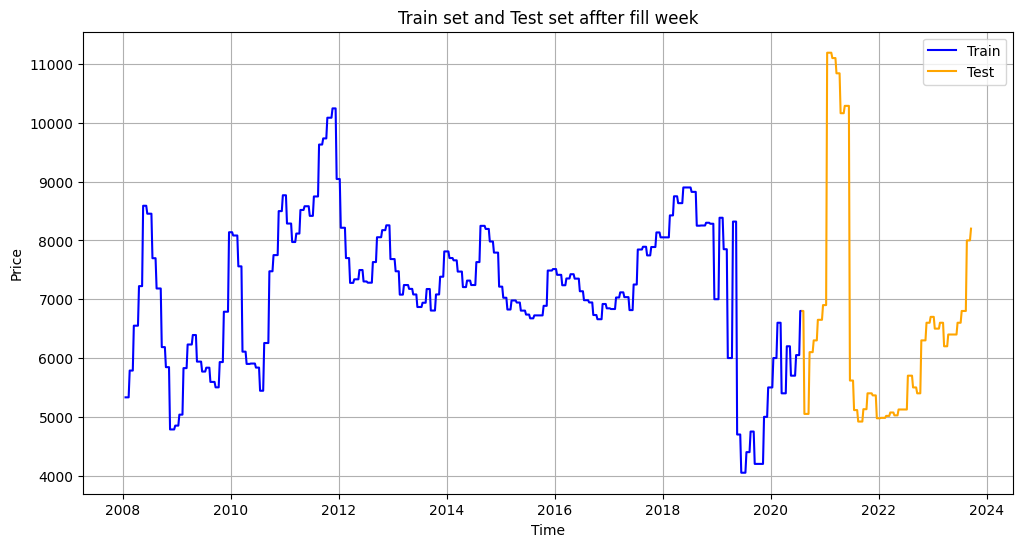

In [56]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE cho tập train và test
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth cho tập train
plt.plot(train_data['price'], label='Train', color='blue')

# Vẽ đường ground truth cho tập test
plt.plot(test_data['price'], label='Test', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Train set and Test set affter fill week')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


Dữ liệu được điền theo tuần với giá trị bằng nhau trong cùng 1 tháng. Sau đó chia tập dữ liệu với tập huấn luyện 80% và tập kiểm thử 20% tạo ra bộ dữ liệu huấn luyện với 654 giá trị, kiểm thử 164 giá trị. 

In [57]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [58]:
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (654, 1)
Test data shape:  (164, 1)


In [59]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset(X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.squeeze(np.array(Xs), axis=-1), np.array(ys),
# Gia 12 thang
look_back = 48
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (606, 48)
y_train.shape:  (606, 1)
X_test.shape:  (116, 48)
y_test.shape:  (116, 1)


In [60]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

def evaluate_predict(model, x, y, name_model):

    y_pred = model.predict(x)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_label = scaler.inverse_transform(y)

    # Evaluate the model
    mse = mean_squared_error(y_label, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_label, y_pred)
    mape = mean_absolute_percentage_error(y_label, y_pred)
   
    print("Đánh giá mô hình " + name_model)
    df_eval = pd.DataFrame(data= {'MSE': [mse], 'RMSE': [rmse], "R2": [r2], "MAPE": [mape]})
    return df_eval

In [61]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
# Gia 12 thang
look_back = 48
X_rnn_train, y_rnn_train = create_dataset(train_scaled, look_back)
X_rnn_test, y_rnn_test = create_dataset(test_scaled, look_back)

In [62]:
def predict_model(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predict_model_oil(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
    return prediction

In [63]:
def plot_future(prediction, model_name, y_plot_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    y_plot_test =  scaler.inverse_transform(y_plot_test)
    plt.plot(np.arange(range_future), np.array(y_plot_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
       

### LSTM

Mô hình LSTM gồm ba lớp LSTM xếp chồng lên nhau, mỗi lớp có 64 units. Mỗi lớp LSTM được theo sau bởi một lớp Dropout với tỷ lệ Dropout là 0,2. Lớp cuối cùng là một lớp Dense với 1 đơn vị, tương ứng với giá trị dự đoán. Mô hình được biên dịch bằng hàm mất mát trung bình bình phương (mean squared error) và bộ tối ưu hóa Adam. 

In [64]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences=True, 
                            input_shape=(X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

### GRU

Mô hình gồm 3 lớp GRU với 64 units, mỗi lớp GRU được theo sau bởi một lớp Dropout với tỷ lệ Dropout là 0,2. Lớp cuối cùng là một lớp Dense với 1 đơn vị, tương ứng với giá trị dự đoán ngày tiếp theo. Mô hình được biên dịch bằng hàm mất mát trung bình bình phương (mean squared error) và bộ tối ưu hóa Adam. 

In [65]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = (X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
      # Hidden layer
    model.add(GRU (units = units,  return_sequences=True))                
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(GRU(units = units))                        
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [66]:
def fit_model(model):
    history = model.fit(X_rnn_train, y_rnn_train, epochs = 100, batch_size = 32, shuffle = False)
    return history

In [67]:
history_gru = fit_model(model_gru)

Epoch 1/100
19/19 [==============================] - 6s 34ms/step - loss: 0.0450
Epoch 2/100
19/19 [==============================] - 1s 34ms/step - loss: 0.0154
Epoch 3/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0144
Epoch 4/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0116
Epoch 5/100
19/19 [==============================] - 1s 48ms/step - loss: 0.0104
Epoch 6/100
19/19 [==============================] - 1s 35ms/step - loss: 0.0092
Epoch 7/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0088
Epoch 8/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0074
Epoch 9/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0071
Epoch 10/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0070
Epoch 11/100
19/19 [==============================] - 1s 38ms/step - loss: 0.0068
Epoch 12/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0071
Epoch 13/100
19/19 [=====

In [68]:
history_lstm = fit_model(model_lstm)

Epoch 1/100


19/19 [==============================] - 7s 107ms/step - loss: 0.0522
Epoch 2/100
19/19 [==============================] - 1s 52ms/step - loss: 0.0196
Epoch 3/100
19/19 [==============================] - 1s 55ms/step - loss: 0.0189
Epoch 4/100
19/19 [==============================] - 1s 71ms/step - loss: 0.0182
Epoch 5/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0167
Epoch 6/100
19/19 [==============================] - 1s 75ms/step - loss: 0.0163
Epoch 7/100
19/19 [==============================] - 1s 62ms/step - loss: 0.0132
Epoch 8/100
19/19 [==============================] - 1s 65ms/step - loss: 0.0114
Epoch 9/100
19/19 [==============================] - 2s 123ms/step - loss: 0.0116
Epoch 10/100
19/19 [==============================] - 3s 149ms/step - loss: 0.0109
Epoch 11/100
19/19 [==============================] - 3s 106ms/step - loss: 0.0103
Epoch 12/100
19/19 [==============================] - 2s 81ms/step - loss: 0.0105
Epoch 13/100
19/19 [=============

In [69]:
evaluate_predict(model_gru, X_rnn_train, y_rnn_train, 'GRU trên tập train').head()

19/19 [==============================] - 1s 11ms/step
Đánh giá mô hình GRU trên tập train


,MSE,RMSE,R2,MAPE
0,140385.44031,374.680451,0.897665,0.039966


In [70]:
y_pred = model_gru.predict(X_rnn_train)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_label = scaler.inverse_transform(y_rnn_train)

19/19 [==============================] - 0s 10ms/step


In [71]:
y_pred.shape

(606, 1)

In [72]:
y_label.shape

(606, 1)

In [73]:
evaluate_predict(model_gru, X_rnn_test, y_rnn_test, 'GRU trên tập test').head()

4/4 [==============================] - 0s 11ms/step
Đánh giá mô hình GRU trên tập test


,MSE,RMSE,R2,MAPE
0,229962.028082,479.543562,0.648562,0.07934


In [74]:
evaluate_predict(model_lstm, X_rnn_train, y_rnn_train, 'LSMT trên tập train').head()

19/19 [==============================] - 1s 12ms/step
Đánh giá mô hình LSMT trên tập train


,MSE,RMSE,R2,MAPE
0,88488.714287,297.470527,0.935496,0.023025


In [75]:
evaluate_predict(model_lstm, X_rnn_test, y_rnn_test, 'LSTM trên tập test').head()

4/4 [==============================] - 0s 12ms/step
Đánh giá mô hình LSTM trên tập test


,MSE,RMSE,R2,MAPE
0,56609.629499,237.927782,0.913487,0.030094


1/4 [======>.......................] - ETA: 0s

19/19 [==============================] - 0s 9ms/step


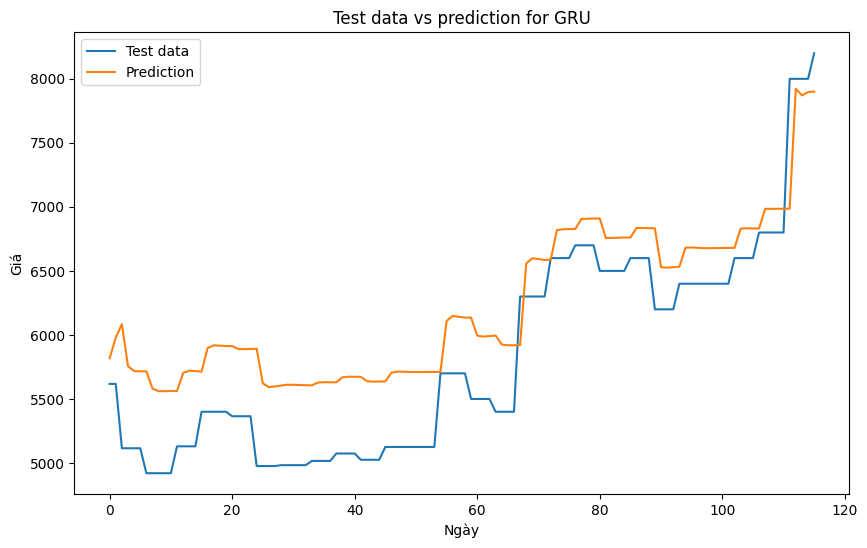

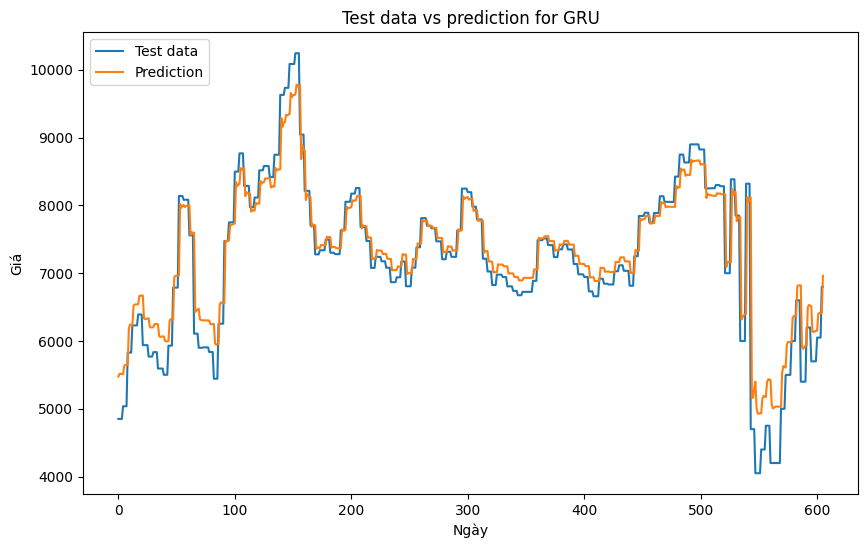

In [76]:
plot_future(predict_model(model_gru, X_rnn_test), 'GRU', y_rnn_test)
plot_future(predict_model(model_gru, X_rnn_train), 'GRU', y_rnn_train)

19/19 [==============================] - 0s 12ms/step


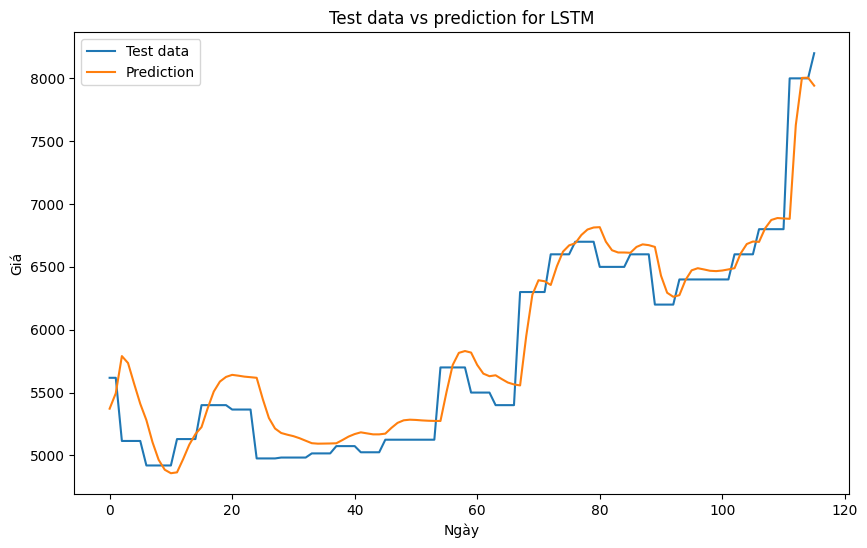

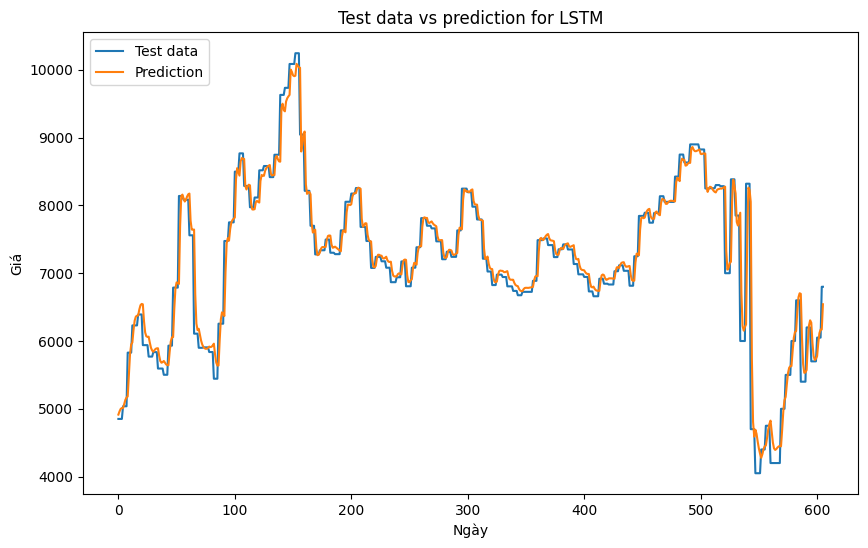

In [77]:
plot_future(predict_model(model_lstm, X_rnn_test), 'LSTM', y_rnn_test)
plot_future(predict_model(model_lstm, X_rnn_train), 'LSTM', y_rnn_train)

### Dự đoán 

In [78]:
def predict(forecast_num, model,data,look_back):
  prediction_list = data[-look_back:]

  for _ in range(forecast_num):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back-1:]

  return prediction_list

def predict_dates(forecast_num, data):
    last_date = data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=forecast_num+1).tolist()
    return prediction_dates

def predict_new_date(model, days, timestep):
  forecast_num = 12 #number of day to predict after the last date in data
  forecast=predict(days, model=model,data=X_test[-1:],look_back=timestep)
  forecast_date=predict_dates(forecast_num, df)
  return scaler.inverse_transform(forecast.reshape(-1, 1))

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step


Text(0, 0.5, 'Giá')

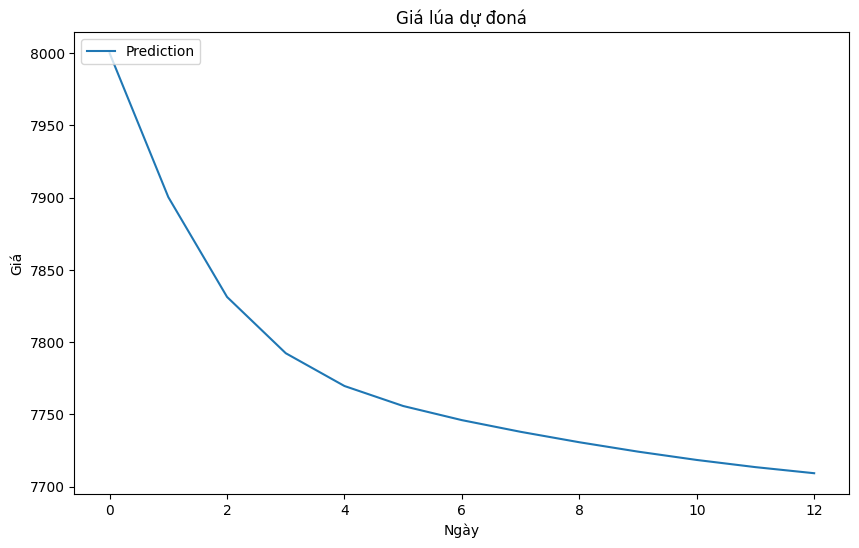

In [79]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_gru, 12, 48)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá lúa dự đoná')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

1/1 [==============================] - 0s 20ms/step


Text(0, 0.5, 'Giá')

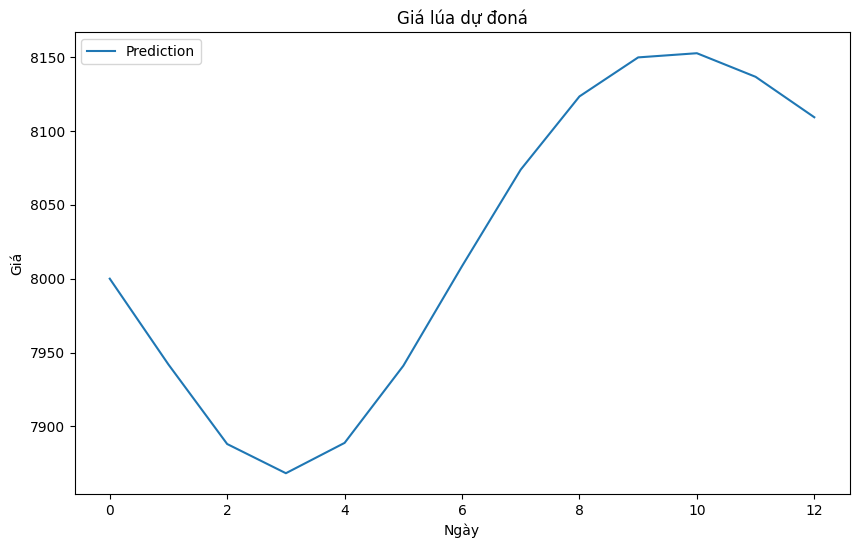

In [80]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_lstm, 12, 48)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá lúa dự đoná')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

### Model XGBoost

Mô hình XGBoost được xây dựng với mục tiêu hồi quy là squarederror (bình phương sai số), độ sâu cây quyết định là 4, learning rate là 0.1, số lượng cây quyết định là 40. 

In [81]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

In [82]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=4, 
                             learning_rate=0.1, 
                             n_estimators=40, 
                            )
model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [83]:
evaluate_predict(model_xgb, X_train_xgb, y_train_xgb, 'XGBoost trên tập train').head()

Đánh giá mô hình XGBoost trên tập train


,MSE,RMSE,R2,MAPE
0,20494.161551,143.15782,0.985061,0.01206


In [84]:
evaluate_predict(model_xgb, X_test_xgb, y_test_xgb, 'XGBoost trên tập test').head()

Đánh giá mô hình XGBoost trên tập test


,MSE,RMSE,R2,MAPE
0,99854.812528,315.998121,0.847397,0.042186


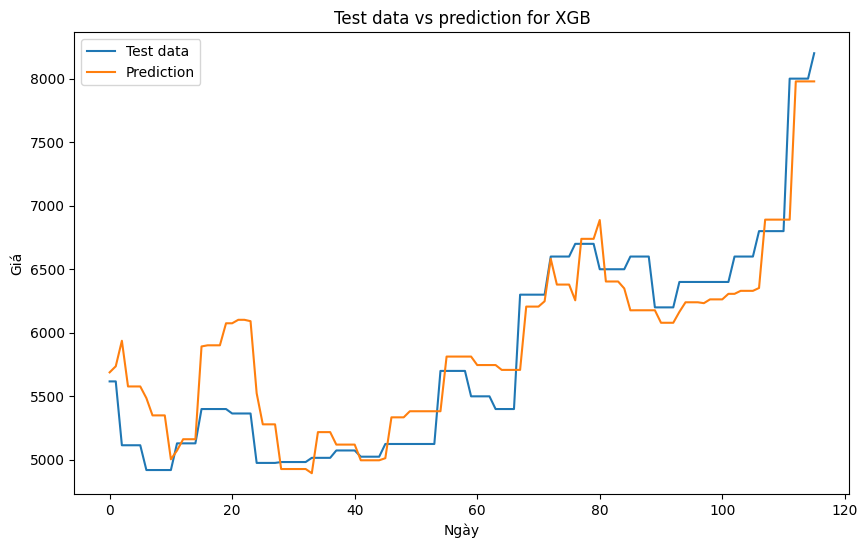

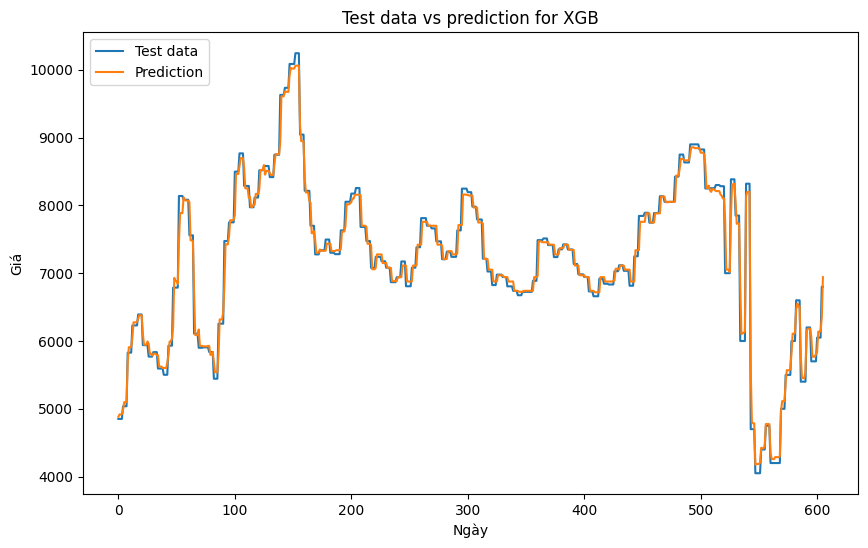

In [85]:
plot_future(predict_model_oil(model_xgb, X_test), 'XGB', y_test)
plot_future(predict_model_oil(model_xgb, X_train), 'XGB', y_train)

In [86]:
# DỰ ĐOÁN NGÀY TIẾP THEO
def predict_new_day(model, days, timesteps):
    df_pre = df.copy()
    df_pre_transform = scaler.transform(df_pre)

    # Lấy dữ liệu cuối cùng từ tập dữ liệu
    last_data = df_pre_transform[-timesteps:]
    last_data = last_data.reshape(1, -1)[:, -(timesteps - 1):]

    predicted_prices = []
    for day in range(days):
        next_prediction = model.predict(last_data)
        last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
        predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
        predicted_prices.append(predicted_price[0, 0])
        
    last_date = df_pre.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

    predicted_df = pd.DataFrame(index = future_dates, columns=['price'])

    for day, price in enumerate(predicted_prices, start=1):
        predicted_df.loc[last_date + pd.DateOffset(days=day)] = price

    df_pre = pd.concat([df_pre, predicted_df], axis=0)
    return df_pre, predicted_df

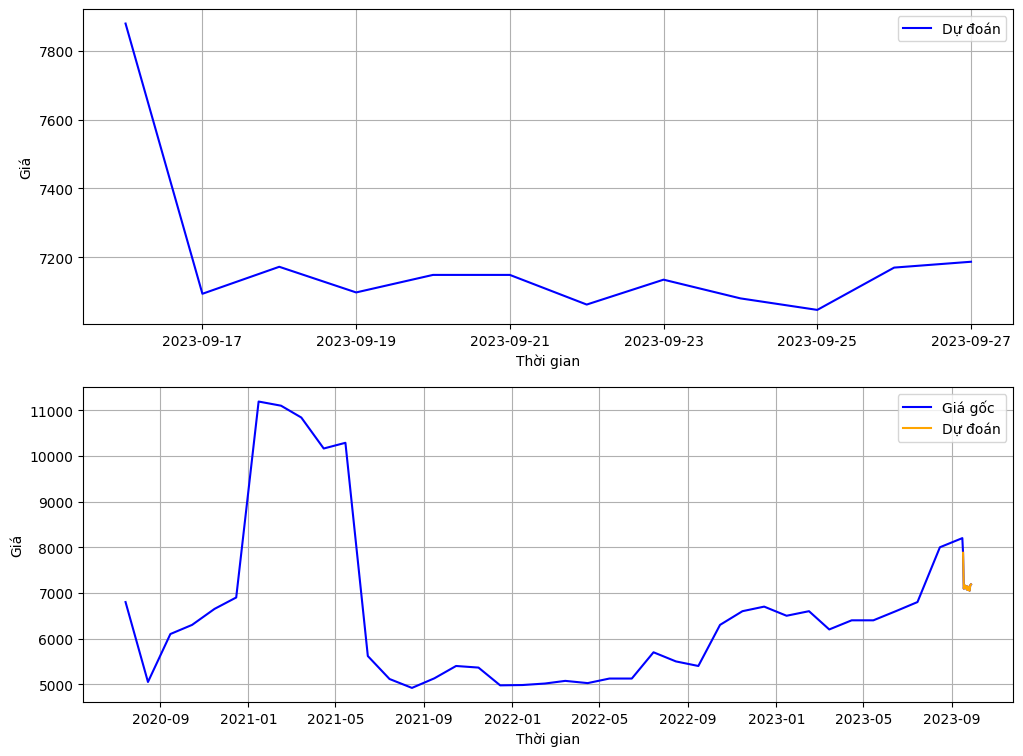

In [87]:
def plot_pred_data(model, day, timesteps):
    predicted_df_xgb, predicted_df = predict_new_day(model, day, timesteps)

    figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 9)) 

    ax1.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='blue')

    ax1.set_xlabel('Thời gian')
    ax1.set_ylabel('Giá')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(predicted_df_xgb[150:].index, predicted_df_xgb[150:]['price'], label='Giá gốc', color='blue')
    ax2.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='orange')

    ax2.set_xlabel('Thời gian')
    ax2.set_ylabel('Giá')
    ax2.legend()
    ax2.grid(True)

    # Hiển thị biểu đồ
    plt.show()

plot_pred_data(model_xgb, 12, 49)

### Random Forest

Mô hình Random Forest xây dựng với số lượng cây quyết định là 60, độ sâu của mỗi cây là 5. 

In [88]:
X_train_rf, y_train_rf = X_train, y_train
X_test_rf, y_test_rf = X_test, y_test

In [89]:
# Tạo và huấn luyện mô hình Random Forest
model_rf = RandomForestRegressor(n_estimators=60, max_depth=5)

model_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, n_estimators=60)

In [90]:
evaluate_predict(model_rf, X_train_rf, y_train_rf, 'Random forest trên tập train').head()

Đánh giá mô hình Random forest trên tập train


,MSE,RMSE,R2,MAPE
0,36204.965694,190.276025,0.973608,0.015584


In [91]:
evaluate_predict(model_rf, X_test_rf, y_test_rf, 'Random forest trên tập test').head()

Đánh giá mô hình Random forest trên tập test


,MSE,RMSE,R2,MAPE
0,102153.383817,319.61443,0.843885,0.043613


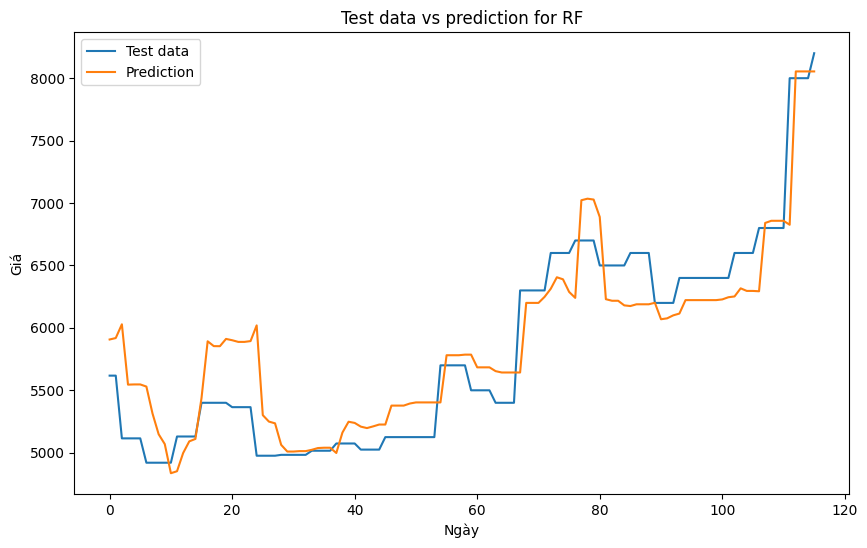

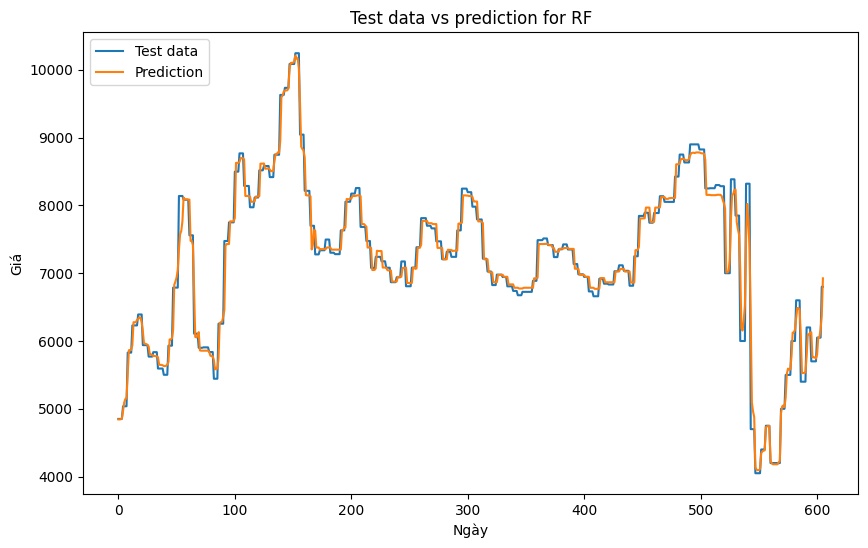

In [92]:
plot_future(predict_model_oil(model_rf, X_test), 'RF', y_test)
plot_future(predict_model_oil(model_rf, X_train), 'RF', y_train)

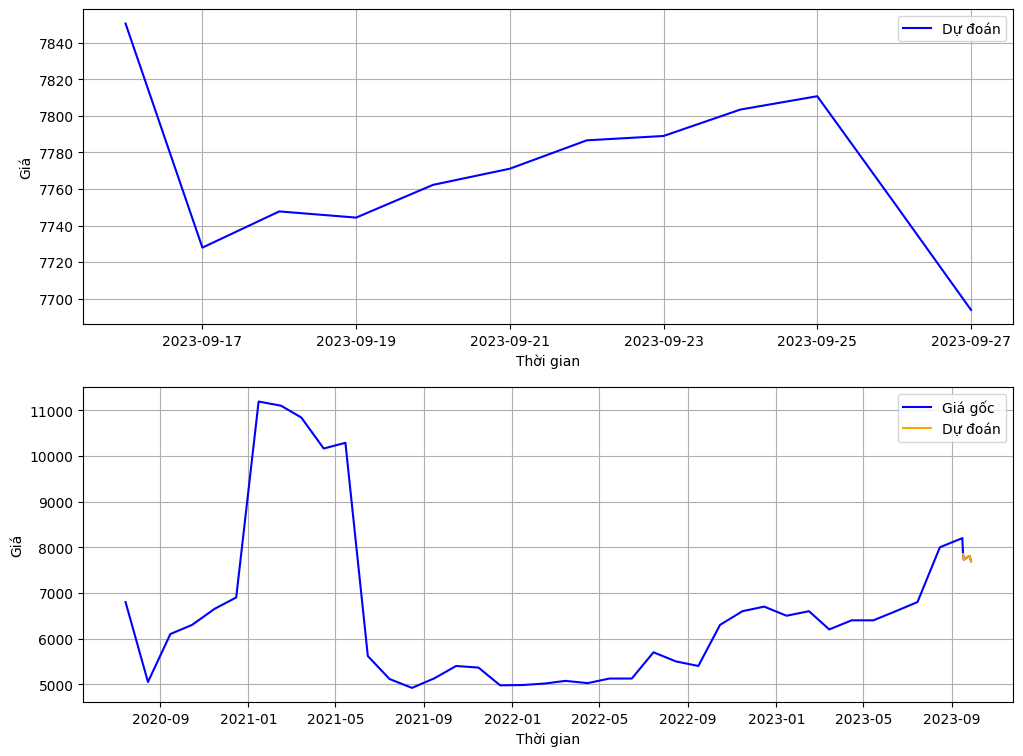

In [93]:
plot_pred_data(model_rf, 12, 49)

### SVM

Mô hình SVM sử dụng thuật toán hồi quy (Support Vector Regression – SVR) với tham số kiểm soát đàn hồi của mô hình C=5. Loại kernel được sử dụng là kernel hạt nhân RBF (Radial Basis Function), thường sử dụng với dữ liệu không tuyến tính. Tham số gamma = ‘auto’ điều chỉnh hình dạng của hạt nhân RBF và epsilon = 0.01 kiểm soát độ rộng của vùng hỗ trợ (margin), nó đặt ngưỡng cho sai số mà mô hình có thể chấp nhận trong quá trình tối ưu. 

In [94]:
X_train_svm, y_train_svm = X_train, y_train
X_test_svm, y_test_svm = X_test, y_test

In [95]:
model_svm = SVR(C=5, kernel='rbf', gamma='auto', epsilon=0.01)

model_svm.fit(X_train_svm, y_train_svm)

SVR(C=5, epsilon=0.01, gamma='auto')

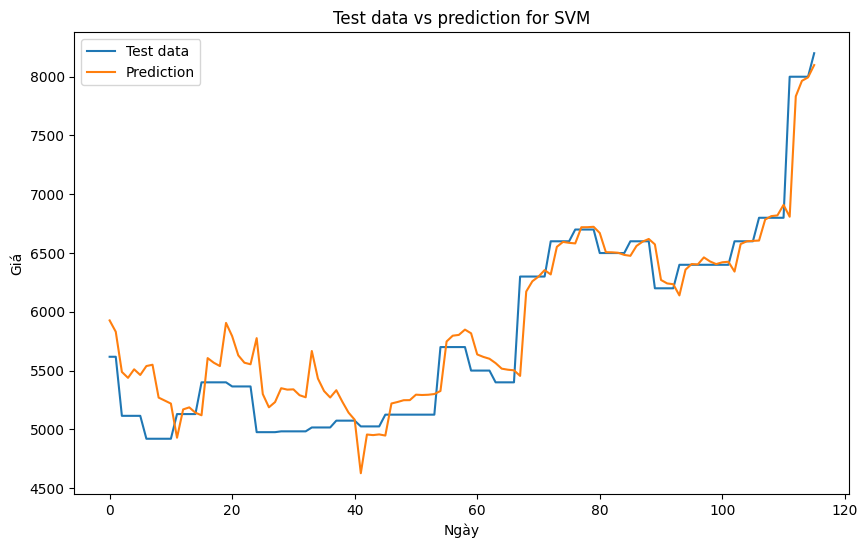

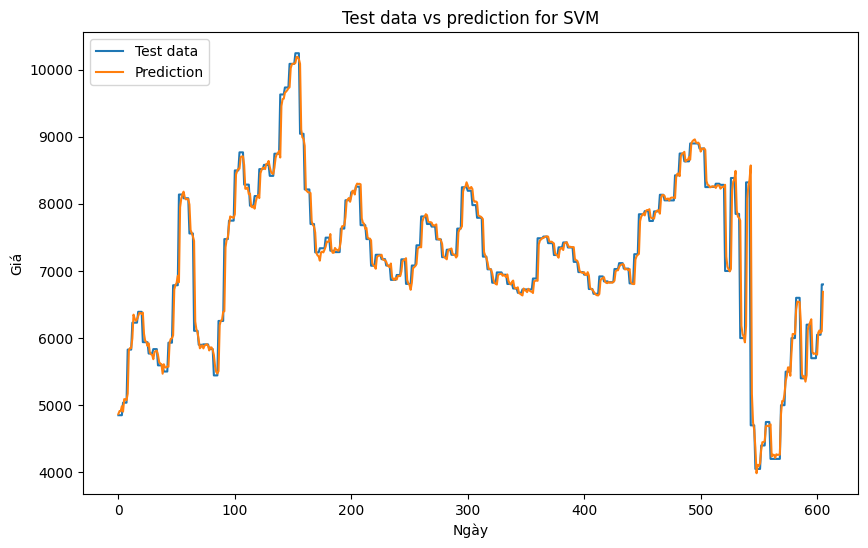

In [96]:
plot_future(predict_model_oil(model_svm, X_test), 'SVM', y_test)
plot_future(predict_model_oil(model_svm, X_train), 'SVM', y_train)

In [97]:
evaluate_predict(model_svm, X_train_svm, y_train_svm, 'SVM trên tập train').head()

Đánh giá mô hình SVM trên tập train


,MSE,RMSE,R2,MAPE
0,75799.474239,275.317043,0.944746,0.015284


In [98]:
evaluate_predict(model_svm, X_test_svm, y_test_svm, 'SVM trên tập test').head()

Đánh giá mô hình SVM trên tập test


,MSE,RMSE,R2,MAPE
0,71324.341051,267.066174,0.890999,0.033428


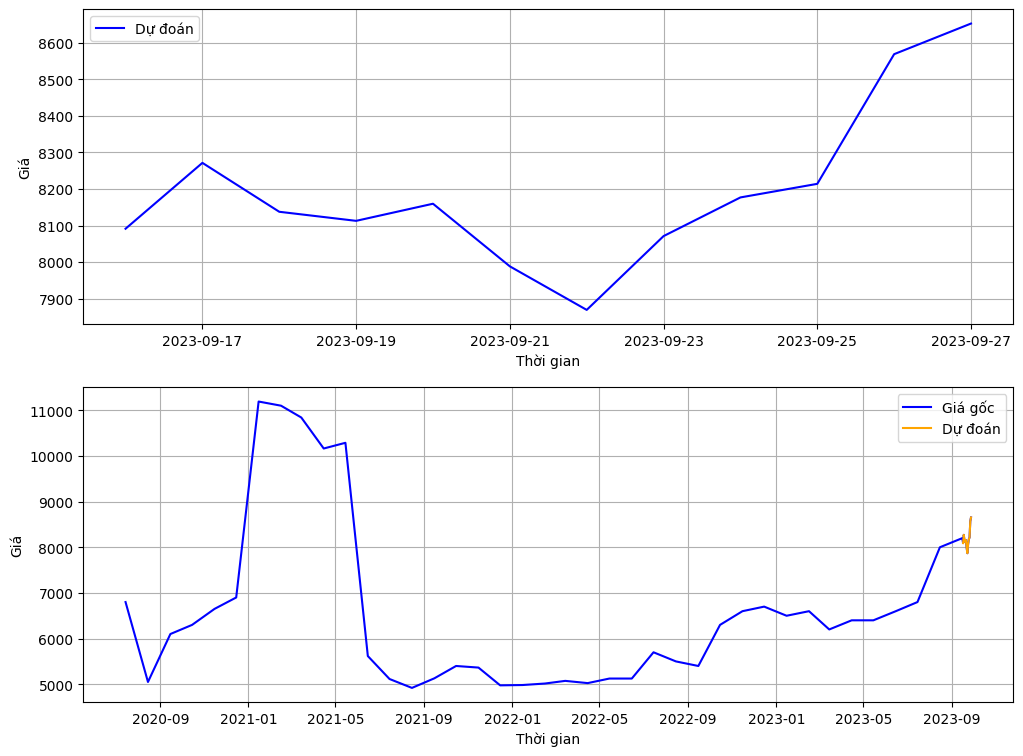

In [99]:
plot_pred_data(model_svm, 12, 49)

In [100]:
import joblib

# save the model to a file
joblib.dump(model_lstm, './algricultural/model_lstm.joblib')
joblib.dump(model_gru, './algricultural/model_gru.joblib')
joblib.dump(model_xgb, './algricultural/model_xgboost.joblib')
joblib.dump(model_rf, './algricultural/model_randomforest.joblib')
joblib.dump(model_svm, './algricultural/model_svm.joblib')



['./algricultural/model_svm.joblib']

## KẾT LUẬN

| Model          |   RMSE |
|:--------------:|--------------:|
| LSTM           |         361.68 |
| GRU            |         208.34 |
| XGBoost        |         316.00 |
| Random Forest  |         328.49 |
| SVM            |         267.07 |
